## Adapted from arch univariate_volatility_modeling


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

### Use sqlalchemy to read USEQ_HIST database

In [32]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://localhost', connect_args={'read_default_file': '~/.myuseq.cnf'})
conn = engine.connect()

In [33]:
import pandas as pd

SQL_query = pd.read_sql_query(
    '''select tradedate, pct_close from USEQ_HIST where symbol='MS'
    and volume>0 order by tradedate''',
    conn,
    index_col='tradedate'
)

df = pd.DataFrame(SQL_query, columns=['pct_close'])

df.head()


,pct_close
tradedate,
2001-01-02,-8.99684
2001-01-03,16.04270
2001-01-04,5.97443
2001-01-05,-4.58902
2001-01-08,-1.47719


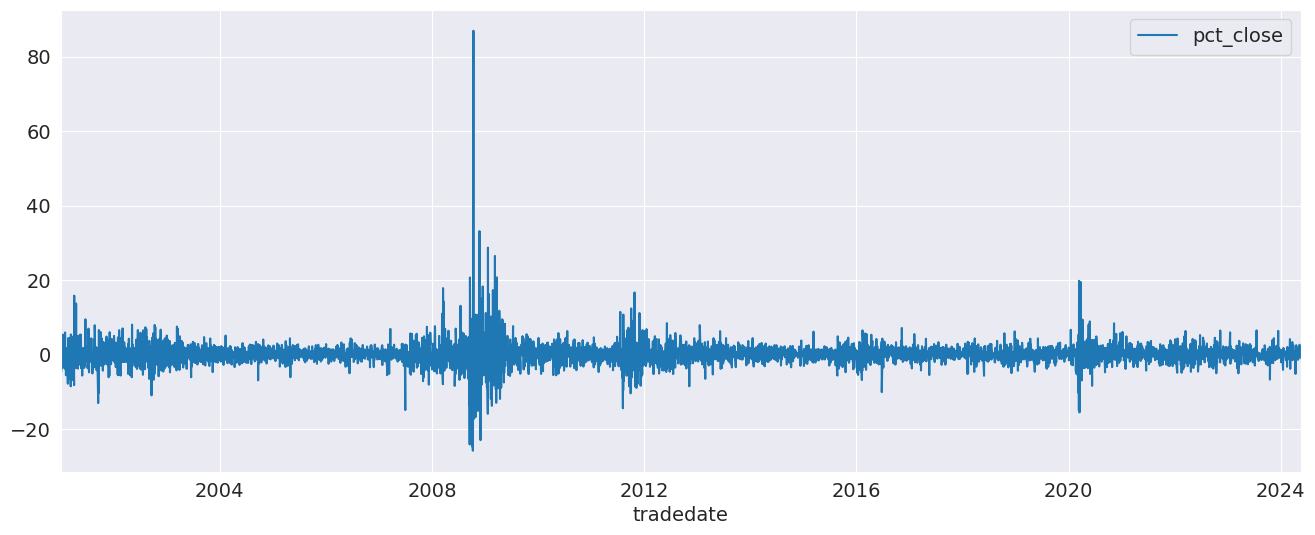

In [34]:
ax = df.plot()
xlim = ax.set_xlim(df.index.min(), df.index.max())

In [35]:
from arch import arch_model

am = arch_model(df)
res = am.fit(update_freq=5)
print(res.summary())
print("likelihood ", res.loglikelihood)

Iteration:      5,   Func. Count:     34,   Neg. LLF: 12724.276855036189
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12652.44279607772
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12652.442103096348
            Iterations: 14
            Function evaluations: 81
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              pct_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12652.4
Distribution:                  Normal   AIC:                           25312.9
Method:            Maximum Likelihood   BIC:                           25339.6
                                        No. Observations:                 5881
Date:                Sun, Jul 07 2024   Df Residuals:                     5880
Time:        

`plot()` can be used to quickly visualize the standardized residuals and conditional volatility.


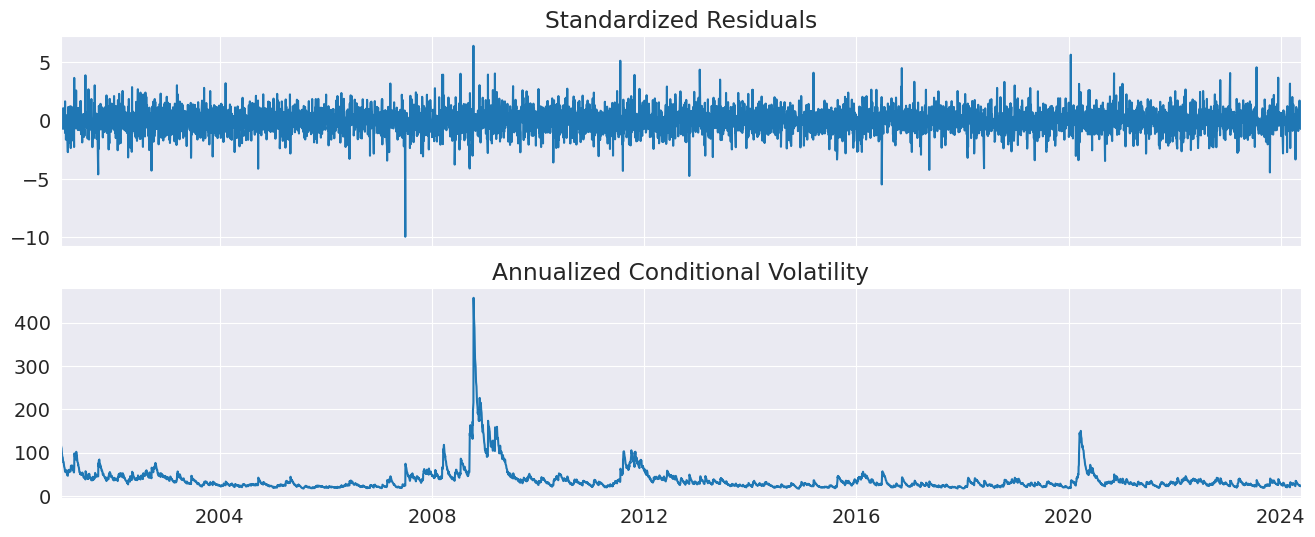

In [36]:
fig = res.plot(annualize="D")

## Forecasts

In [37]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])

                 h.1
tradedate           
2024-05-17  0.084439
                 h.1
tradedate           
2024-05-17  1.929191
                 h.1
tradedate           
2024-05-17  1.929191
                 h.1       h.2       h.3       h.4       h.5
tradedate                                                   
2024-05-17  1.929191  1.981225  2.032639  2.083441  2.133639


### GJR-GARCH

In [38]:
am = arch_model(df, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:              pct_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -12586.7
Distribution:                  Normal   AIC:                           25183.5
Method:            Maximum Likelihood   BIC:                           25216.9
                                        No. Observations:                 5881
Date:                Sun, Jul 07 2024   Df Residuals:                     5880
Time:                        00:29:24   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0288  2.310e-02      1.247      0.212 

## Forecasts

In [39]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])

forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])

                 h.1
tradedate           
2024-05-17  0.028809
                 h.1       h.2       h.3       h.4       h.5
tradedate                                                   
2024-05-17  1.843342  1.894508  1.945102  1.995128  2.044595


The log likelihood improves substantially with the introduction of an asymmetric term, and the parameter estimate is significant.

### TARCH/ZARCH

In [40]:
am = arch_model(df, p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     45,   Neg. LLF: 12876.200034965206
Iteration:     10,   Func. Count:     78,   Neg. LLF: 12582.591848847569
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12582.59175602475
            Iterations: 13
            Function evaluations: 95
            Gradient evaluations: 13
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:              pct_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -12582.6
Distribution:                  Normal   AIC:                           25175.2
Method:            Maximum Likelihood   BIC:                           25208.6
                                        No. Observations:                 5881
Date:                Sun, Jul 07 2024   Df Residuals:                     5880
Time:        

The fit hasn't changed much
### Student's T Errors

Financial returns are often heavy tailed, and a Student's T distribution is a simple method to capture this feature.  The call to `arch` changes the distribution from a Normal to a Students's T.

The standardized residuals appear to be heavy tailed with an estimated degree of freedom near 6. (nu =~ 6 which is 8-2, 2 dofs for mean and std dev?) The log-likelihood also shows a large increase.

In [41]:
am = arch_model(df, p=1, o=1, q=1, power=1.0, dist="StudentsT")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     49,   Neg. LLF: 12858.327225888239
Iteration:     10,   Func. Count:     86,   Neg. LLF: 12398.644548967142
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12398.644461759828
            Iterations: 13
            Function evaluations: 117
            Gradient evaluations: 13
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -12398.6
Distribution:      Standardized Student's t   AIC:                           24809.3
Method:                  Maximum Likelihood   BIC:                           24849.4
                                              No. Observations:                 5881
Date:                      Sun, Jul 07 2024   Df

## GJR-Garch with Student's T

In [42]:
am = arch_model(df, p=1, o=1, q=1, dist="StudentsT")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     43,   Neg. LLF: 23032.341727190862
Iteration:     10,   Func. Count:     84,   Neg. LLF: 12409.9612894639
Iteration:     15,   Func. Count:    123,   Neg. LLF: 12403.245234786078
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12403.240402976204
            Iterations: 18
            Function evaluations: 145
            Gradient evaluations: 18
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -12403.2
Distribution:      Standardized Student's t   AIC:                           24818.5
Method:                  Maximum Likelihood   BIC:                           24858.6
                                              No. Observations

## Forecasts

In [43]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])

forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])


                 h.1
tradedate           
2024-05-17  0.035278
                 h.1       h.2       h.3       h.4       h.5
tradedate                                                   
2024-05-17  1.870509  1.905548  1.940333  1.974864  2.009144


## Fixing Parameters
In some circumstances, fixed rather than estimated parameters might be of interest.  A model-result-like class can be generated using the `fix()` method.  The class returned is identical to the usual model result class except that information about inference (standard errors, t-stats, etc) is not available.

In [44]:
fixed_res = am.fix([0.0235, 0.01, 0.06, 0.0, 0.9382, 8.0])
print(fixed_res.summary())

                       Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                     pct_close   R-squared:                          --
Mean Model:                    Constant Mean   Adj. R-squared:                     --
Vol Model:                         GJR-GARCH   Log-Likelihood:               -12472.2
Distribution:       Standardized Student's t   AIC:                           24956.4
Method:            User-specified Parameters   BIC:                           24996.5
                                               No. Observations:                 5881
Date:                       Sun, Jul 07 2024                                         
Time:                               00:29:24                                         
      Mean Model     
                 coef
---------------------
mu             0.0235
   Volatility Model  
                 coef
---------------------
omega          0.0100
alpha[1]       0.0600
gamma[1]       0.0000
beta[1

(11324.0, 19860.0)

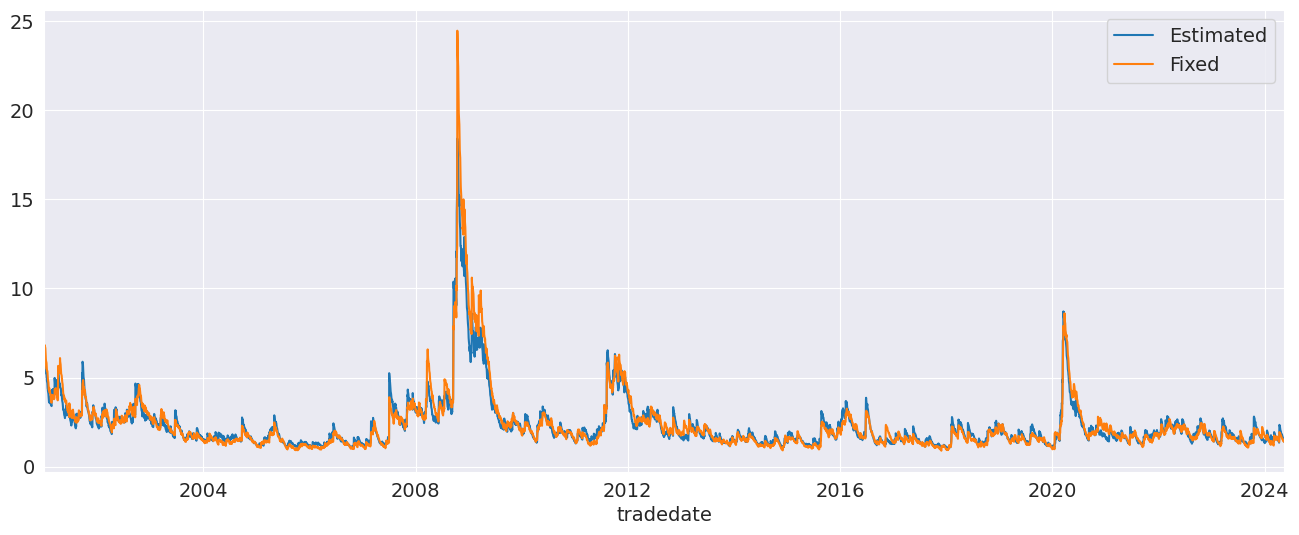

In [45]:
import pandas as pd

df = pd.concat([res.conditional_volatility, fixed_res.conditional_volatility], axis=1)
df.columns = ["Estimated", "Fixed"]
subplot = df.plot()
subplot.set_xlim(xlim)

## Close database

In [46]:
conn.close()